# Monte-carlo simulations

Xrmc and xmim-sim are used for simulation. The sample coordinate system is defined so that the beam travels along the Y-axis, the Z-axis points upwards and the X-axis is parallel with the synchrotron plane, pointing to the left when looking upstream. The detector reference frame (before transformation) is defined so that the Z-axis points upstream, the X-axis (detector image rows) points upwards and the Y-axis (detector image columns) points to the right when looking upstream.

Units are cm (distance), keV (energy) and seconds (time) unless noted otherwise.

In [1]:
from spectrocrunch.simulation.xrmc import XrmcWorldBuilder, loadxrmcresult, showxrmcresult
import numpy as np
import matplotlib.pyplot as plt

#experiments = ['xanes', 'imaging', 'scattering', 'xrf']
experiments = ['xrf']

### Measured data

In [2]:
from spectrocrunch.geometries import qxrf
from spectrocrunch.io import xiaedf
from spectrocrunch.io import spec

def load_xrf(name=None):
    if name == 'axo':
        # Calibrate diodes
        params = {'base': '/data/id21/store/backup_visitor/2018/me1494/id21',
                  'sample': 'standards',
                  'dataset': 'spec01',
                  'gaindiodeI0': 1e8,
                  'dark': False,
                  'fixdark': True,
                  'plot': False}
        scans = [{'specnr':105, 'resetdevices': True},
                 {'specnr':106},
                 {'specnr':107}]
        geom = qxrf.factory('sxm')
        geom.batchcalibrate_diodes(params, scans)

        # Load data
        path = '/data/id21/store/backup_visitor/2018/me1494/id21/standards/standards_0007/zap'
        radix = 'standards_0007'
        mapnum = 92
        geom.diodeI0.gain = 1e8
        detectorposition = -23
        xiaimg = xiaedf.xiaimage_number(path,radix,mapnum)
        xiaimg.dtcor(True)
        xiaimg.detectorsum(True)
    else:
        return None
    # Load scan info
    h = xiaimg.header(source='counters')
    parseinfo = geom.instrument.edfparser_info()
    parser = spec.edfheader_parser(**parseinfo)
    h = parser.parse(h)
    
    # Sum spectrum at particular flux and time
    ctridx = xiaimg.counternames().index('arr_iodet')
    I0 = xiaimg.counters[..., ctridx, 0]
    geom.reference = np.nanmedian(I0)
    geom.xrf_positions = [detectorposition]

    energy = h['energy'].to('keV').magnitude
    xrfnormop,refflux,reftime,expotime = geom.xrfnormop(energy,
                                                        expotime=h['time'])
    norm = xrfnormop(I0)[..., np.newaxis]
    mca = xiaimg.data[..., 0]/norm
    reftime *= mca.shape[0]*mca.shape[1]
    mca = mca.sum(axis=(0, 1))
    sourceparams = {'time': reftime, 'flux': refflux, 'energy': energy}
    return {'mca': mca, 'geometry':geom.xrfgeometry, 'source':sourceparams}

  File "/sware/exp/spectrocrunch/2019xrmc_debian8/venv/local/lib/python2.7/site-packages/silx/gui/qt/_qt.py", line 96, in <module>
    since_version='0.9.0')


In [3]:
def load_pulseproctime():
    path = '/data/id21/store/backup_visitor/2018/me1494/id21/LSCF_SDC_72h/LSCF_SDC_72h_mappaprova/zap'
    radix = 'LSCF_SDC_72h_mappaprova'
    mapnum = 1
    xiaimg = xiaedf.xiaimage_number(path,radix,mapnum)
    icr, ocr = xiaimg.stats[...,0].T
    icr = icr.flatten()
    ocr = ocr.flatten()
    dtfrac = (icr-ocr)/icr.astype(float)
    return np.nanmedian(-np.log(1-dtfrac)/icr)

### Source

In [4]:
from spectrocrunch.sources import xray as xraysources
from spectrocrunch.materials import pymca

def define_source(source=None, energy=7.5, flux=1e9, time=1):
    if source is None:
        source = xraysources.factory("synchrotron")
    pymcahandle = pymca.PymcaHandle(energy=energy,
                                    flux=flux,
                                    time=time,
                                    linear=True,
                                    escape=True,
                                    snip=True,
                                    scatter=True)
    return source, pymcahandle

def world_addsource(world, pymcahandle, fullfield=False):
    distance = 42e2  # doesn't really matter
    # Beamsize at the sample
    if fullfield:
        beamsize = 100e-4  # cm
    else:
        beamsize = 1e-4  # cm
    world.definesource(flux=pymcahandle.flux.to('Hz').magnitude,
                       energy=pymcahandle.energy,
                       distance=distance,
                       beamsize=beamsize)

### Diode

Angles are defined with respect to the beam direction (angle=0 deg).

In [5]:
def world_adddiode(world, angle=0, multiplicity=10):
    forcedetect = False
    poissonnoise = False
    distance = 10  # cm
    activearea = 1  # cm^2
    world.adddiode(distance=distance, activearea=activearea,
                   orientation_inplane=angle, orientation_outplane=0,
                   poissonnoise=poissonnoise, ebinsize=None,
                   forcedetect=forcedetect, multiplicity=multiplicity,
                   time=pymcahandle.time.to('s').magnitude)

### XRF detector

Angles are defined with respect to the beam direction (angle=0 deg).

In [6]:
from spectrocrunch.materials import multilayer
from spectrocrunch.detectors import xrf as xrfdetectors
from spectrocrunch.geometries import xrf as xrfgeometries

def define_xrfgeometry(source):
    detector = xrfdetectors.factory("leia")
    geometry = xrfgeometries.factory("sxm120",
                                     detector=detector,
                                     source=source)
    return geometry

def world_addsdd(world, geometry, angle=None, convoluted=False,
                 pulseproctime=0, multiplicity=10):
    forcedetect = True
    poissonnoise = False
    distance = geometry.distance.to('cm').magnitude
    activearea = geometry.detector.activearea.to('cm**2').magnitude
    ebinsize = geometry.detector.mcagain  # keV
    if angle is None:
        angle = geometry.anglein + geometry.angleout
    if convoluted:
        detectormaterial = geometry.detector.material
        detectorthickness = geometry.detector.thickness

        window = geometry.detector.detectorfilters()
        material = [w['material'] for w in window]
        thickness = [w['thickness'] for w in window]
        windowmaterial = multilayer.Multilayer(material=material,
                                               thickness=thickness,
                                               name='sddwindow')
        windowthickness = sum(windowmaterial.thickness)
        windowmaterial = windowmaterial.mixlayers()
        if hasattr(windowmaterial, 'tocompound'):
            windowmaterial = windowmaterial.tocompound()

        world.addmaterial(detectormaterial)
        world.addmaterial(windowmaterial)
        response = {'material': detectormaterial.name,
                    'thickness': detectorthickness,
                    'windowmaterial': windowmaterial.name,
                    'windowthickness': windowthickness,
                    'noise': geometry.detector.mcanoise,
                    'fano': geometry.detector.mcafano,
                    'pulseproctime': pulseproctime}
    else:
        response = {}
    world.addxrfdetector(distance=distance, activearea=activearea,
                         orientation_inplane=angle, orientation_outplane=0,
                         ebinsize=ebinsize, poissonnoise=poissonnoise,
                         forcedetect=forcedetect, multiplicity=multiplicity,
                         response=response, time=pymcahandle.time.to('s').magnitude)
    if convoluted:
        geometry.detector.mcagain = world.detector.mcagain
        geometry.detector.mcazero = world.detector.mcazero

### Imaging camera

In [7]:
def world_addpco(world, multiplicity=10):
    forcedetect = True
    poissonnoise = False
    distance = 5  # cm
    shift = 0.000, 0.000  # cm
    angle = np.arctan2(shift, distance)*180/np.pi  # deg
    ebinsize = 5e-3  # keV
    n = 128
    projbeamsizetrans = 2 * (world.source.distance + distance) * np.tan(world.source.divergence)
    pixelsize = projbeamsizetrans/n  # beam fits exactly in detector (when angle=[0,0])
    world.addareadetector(distance=distance,
                          pixelsize=(pixelsize, pixelsize), dims=(n, n),
                          orientation_inplane=angle[0], orientation_outplane=angle[1],
                          ebinsize=ebinsize, poissonnoise=poissonnoise,
                          forcedetect=forcedetect, multiplicity=multiplicity,
                          time=pymcahandle.time.to('s').magnitude)

### Sample

In [8]:
from spectrocrunch.materials import compoundfromformula
from spectrocrunch.materials import compoundfromname
from spectrocrunch.materials import compoundfromlist
from spectrocrunch.materials import element
from spectrocrunch.materials import mixture
from spectrocrunch.materials import types
from spectrocrunch.materials import xrfstandards

def define_sample(geometry, name=None):
    if name == 'axo':
        sample = xrfstandards.factory("id21_room",
                                      geometry=geometry,
                                      filmthickness=1e-7,
                                      extraelements=["Ni","Cl","Cr","Al"])
    elif name == 'cell':
        cell = compoundfromname.compoundfromname('ecoli dry')
        cell.addelements(['Ti'], [300e-6], types.fraction.mole)
        frame = compoundfromname.compoundfromname("silicon nitride")
        ultralene = compoundfromname.compoundfromname("ultralene")
        attenuators = [["SampleCover", ultralene, 4.064e-4],
                       ["BeamFilter0", ultralene, 4.064e-4]]
        for k in attenuators:
            geometry.addattenuator(*k)
        sample = multilayer.Multilayer(material=[cell, frame],
                                       thickness=[10e-4, 0.2e-4],
                                       geometry = geometry,
                                       name = 'cell')
    else:
        c1 = compoundfromname.compoundfromname("hematite")
        c2 = compoundfromformula.CompoundFromFormula("PbSO4",density=6.29)
        c3 = compoundfromlist.CompoundFromList(["Ca","C","O"],
                                               [1,1,3],
                                               types.fraction.mole,
                                               density=2.71,
                                               name="calcite")
        toplayer = c1
        substrate = mixture.Mixture([c2,c3],
                                    [0.5,0.5],
                                    types.fraction.mass,
                                    name="Substrate")
        sample = multilayer.Multilayer(material=[toplayer, substrate],
                                       thickness=[10e-4, 20e-4],
                                       geometry = geometry,
                                       name = 'test')
    return sample

def world_addsample(world, sample, fullfield=False):
    projbeamsizesample = 2 * (world.source.distance) * np.tan(world.source.divergence)
    assert world.source.beamsize == projbeamsizesample
    if fullfield:
        # Make sure the entire sample fits in the beam footprint
        samplesize = projbeamsizesample/2.
    else:
        # Make sure the sample is larger than the beam footprint
        samplesize = projbeamsizesample*10
    
    # All layers the same size and beam throught sample center
    nlayers = len(sample)
    dxs = [samplesize]*nlayers
    dys = [samplesize]*nlayers
    oxs = [0]*nlayers
    oys = [0]*nlayers
    
    if sample.name == 'test':
        # Make first layer smaller
        dxs[0] = 3*samplesize/4.
        dys[0] = samplesize/4.
        oxs[0] = (samplesize-dxs[0])/2.
        oys[0] = 0#-(samplesize-dys[0])/2.
    
    world.removesample()
    for layer, dx, dy, ox, oy in zip(sample, dxs, dys, oxs, oys):
        world.addlayer(material=layer.material,
                       thickness=layer.thickness,
                       dhor=dx, dvert=dy, ohor=ox, overt=oy)
    return sample

### Run experiments

In [9]:
from spectrocrunch.io import localfs

def run(world, interactions, simulate=True, plot=True, ylog=False):
    path = localfs.Path(world.main.path)
    if simulate:
        path.remove(recursive=True)
        world.finalize(interactions=interactions)
        if not world.simulate():
            #path.ls(recursive=True)
            raise RuntimeError('Simulation failed')
    else:
        world.finalize(interactions=interactions)
    #if plot:
    #    path.ls(recursive=True)
    data, info = loadxrmcresult(world.detector.outpath, world.detector.name)
    if plot:
        #info.pop('xenergy') # in case you want channels
        showxrmcresult(data, ylog=ylog, **info)
    return data, info

## Imaging

Visualize sample in transmission with a wide beam and an area detector. Test sample and detector rotation.

Positive rotation in the synchrotron plane:
- sample moves to the left when looking upstream
- detector moves to the left when looking upstream

Positive rotation out of the synchrotron plane:
- sample moves below the synchrotron plane
- detector moves below the synchrotron plane

This means rotations are defined as change-of-frame (inverse of object transformation).

In [10]:
if 'imaging' in experiments:
    path = r'/data/id21/tmp/xrmctest/imaging'
    world = XrmcWorldBuilder(path)
    source, pymcahandle = define_source()
    pymcahandle.sample = define_sample(None)
    world_addsource(world, pymcahandle, fullfield=True)
    world_addpco(world)
    world_addsample(world, pymcahandle.sample, fullfield=True)
    world.quadrics.orientation_inplane = 0
    world.quadrics.orientation_outplane = 0
    world.quadrics.add_inplane_rotationloop(90, 1)
    world.quadrics.add_outplane_rotationloop(90, 1)
    data, info = run(world, (10, ), simulate=True)

## XANES
Transmission: diode behind the sample, fluorescence: diode at 110 degrees from the beam (in the synchrotron plane).

In [11]:
if 'xanes' in experiments:
    path = r'/data/id21/tmp/xrmctest/xanes'
    energy = np.linspace(7.05, 7.3, 30)
    world = XrmcWorldBuilder(path)
    source, pymcahandle = define_source()
    pymcahandle.sample = define_sample(None)
    world_addsource(world, pymcahandle)
    world_adddiode(world)
    world_addsample(world, pymcahandle.sample)
    
    for fluo in [False, True]:
        if fluo:
            label = 'fluorescence'
            world.detector.forcedetect = True
            world.detector.orientation_inplane = 110  # degrees
            multiplicity = 0, 100
        else:
            # Do not force detection to get the 0-order (transmission).
            label = 'transmission'
            world.detector.forcedetect = False
            world.detector.orientation_inplane = 0
            multiplicity = (1,)
        # Simulate at each XANES energy:
        counts = np.zeros(energy.size)
        for i, en in enumerate(energy):
            world.spectrum.lines[0][0] = en
            data, info = run(world, multiplicity, simulate=True, plot=False)
            counts[i] = np.squeeze(data[int(fluo)])
        if not fluo:
            counts = -np.log(counts)
        counts -= counts.min()
        counts /= counts.max()
        # Plot XANES spectra
        tmp = plt.plot(energy, counts, label=label)
        plt.xlabel('Energy (keV)')
        plt.ylabel('Normalized XANES')
        plt.title('Exposure time = {} sec'.format(info['time']))
    tmp = plt.legend()

## XRF: scattering

Rotate fluorescence detector from 0 to 180 degrees (in plane of synchrotron).

In [12]:
if 'scattering' in experiments:
    path = r'/data/id21/tmp/xrmctest/xrf'
    world = XrmcWorldBuilder(path)
    energy = 7.5
    angle_start = 0
    angle_end = 180
    source, pymcahandle = define_source(energy=energy)
    geometry = define_xrfgeometry(source=source)
    pymcahandle.sample = define_sample(geometry)
    world_addsource(world, pymcahandle)
    world_addsdd(world, geometry,
                 multiplicity=10,
                 angle=angle_start,
                 convoluted=False)
    world_addsample(world, pymcahandle.sample)
    angle_nsteps = 30
    angle_step = float(angle_end-angle_start)/angle_nsteps
    world.detector.add_inplane_rotationloop(angle_step, angle_nsteps)
    data, info = run(world, (1, 10000, ), simulate=True,
                     ylog=True, plot=False)

Plot evolution of elastic scattering peak

In [13]:
if 'scattering' in experiments:
    idx = np.argmin(np.abs(info['xenergy']-energy))
    y0, y1 = data[..., 0, 0, idx-5:idx+5].sum(axis=-1)
    x = np.linspace(angle_start, angle_end, y1.size)
    tmp = plt.plot(x, y1)
    plt.xlabel('Detector angle (deg)')
    plt.ylabel('Rayleigh counts')
    tmp = plt.title('Exposure time = {} sec'.format(info['time']))

## XRF: detection limits

Monte-carlo simulation of one XRF spectrum

/sware/exp/spectrocrunch/2019xrmc_debian8/venv/local/lib/python2.7/site-packages/pint/quantity.py:1377: UnitStrippedWarning: The unit of the quantity is stripped.
  warnings.warn("The unit of the quantity is stripped.", UnitStrippedWarning)


Data shape: (2, 1, 1, 1, 1801)
Step 0
 Min counts/pixel (for each order): [0. 0.]
 Max counts/pixel (for each order): [     0.         150264.31316065]
 Total counts (for each order): [      0.         9502099.81989432]


/sware/exp/spectrocrunch/2019xrmc_debian8/venv/local/lib/python2.7/site-packages/matplotlib/ticker.py:2207: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "


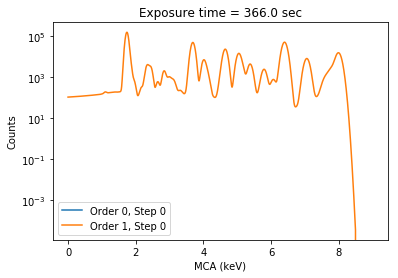

In [14]:
if 'xrf' in experiments:
    path = r'/data/id21/tmp/xrmctest/xrf'
    world = XrmcWorldBuilder(path)
    samplename = 'axo'
    measurement = load_xrf(name=samplename)
    pulseproctime = 0#load_pulseproctime()
    if measurement:
        geometry = measurement['geometry']
        source, pymcahandle = define_source(source=geometry.source, **measurement['source'])
    else:
        source, pymcahandle = define_source()
        geometry = define_xrfgeometry(source=source)
    pymcahandle.ninteractions = 1
    pymcahandle.sample = define_sample(geometry, name=samplename)
    world_addsource(world, pymcahandle)
    world_addsdd(world, geometry,
                 pulseproctime=pulseproctime,
                 multiplicity=10,
                 convoluted=True)
    world_addsample(world, pymcahandle.sample)
    multiplicity = (0,) + (10000,) * pymcahandle.ninteractions
    data, info = run(world, multiplicity, simulate=True,
                     ylog=True, plot=True)
    #ax = plt.gca()
    #ax.set_ylim([0.1, data.max()*10])
    mc_counts = data[:, 0, 0, 0, :].sum(axis=0)
    mc_energy = info['xenergy']

Fit XRF spectrum with pymca + calculate analytical spectrum

In [29]:
from copy import deepcopy

if 'xrf' in experiments:
    #fit_counts = np.random.poisson(np.round(mc_counts).astype(int))
    fit_counts = mc_counts
    pymcahandle.setdata(fit_counts)
    pymcahandle.linear = False
    pymcahandle.snip = True
    geometry.detector.bltail = False
    geometry.detector.bstail = False
    geometry.detector.bstep = False
    geometry.detector.ratios = 0.05, 0.1 , 0.1
    geometry.detector.stailslope_ratio = 0.05
    geometry.detector.ltailslope_ratio = 0.1
    pymcahandle.addtopymca(fresh=True)
    pymcahandlefit = deepcopy(pymcahandle)
    fitresult = pymcahandlefit.fit(loadfromfit=True)
    spectrum = pymcahandle.xrayspectrum(scattering=True,
                                        method='analytical')
    spectrumfit = pymcahandlefit.xrayspectrum(scattering=True,
                                        method='analytical')

In [38]:
import difflib
d = difflib.Differ()
diff = d.compare(str(pymcahandle).split('\n'), str(pymcahandlefit).split('\n'))
#print('\n'.join(diff))

for layer, player in zip(pymcahandle.sample, fitresult['lmassfractions']):
    print(sum(layer.massfractions().values()))
    print(sum(layer.massfractions().values()))

1.0
1.0
1.0
1.0


Plot simulated, fitted, calculated and measured XRF spectra

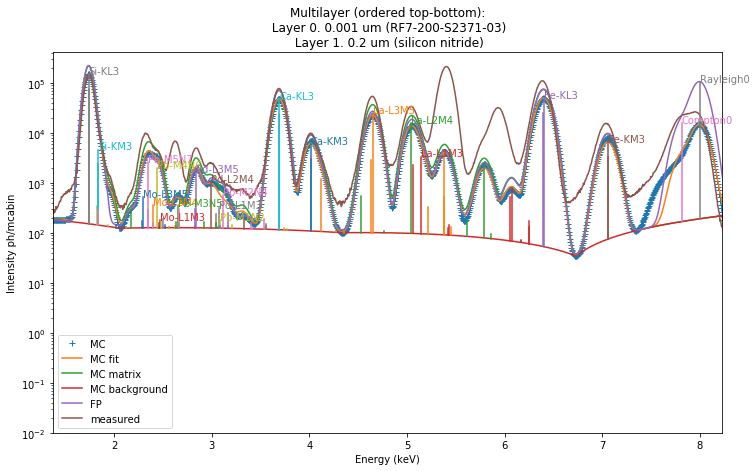

In [17]:
if 'xrf' in experiments:
    # Plot fit result
    plt.figure(figsize=(12,7))
    ylog = True
    fitresult['plot'](ylog=ylog, label='MC')
    matrix_counts = fitresult['ymatrix']
    matrix_energy = fitresult['energy']

    # Plot theoretical spectrum of sample
    backfunc = fitresult['interpol_energy'](fitresult['yback'])
    kwargs = {'histogram': True,
              'fluxtime': pymcahandle.I0,
              'backfunc': backfunc}
    spectrum.plot(decompose=False,
                  legend=True,
                  forcelines=False,
                  sumlabel='FP',
                  **kwargs)
    spectrum_energy, spectrum_counts, label = spectrum.sumspectrum(**kwargs)
    
    # Plot measured spectrum
    if measurement:
        meas_counts = measurement['mca']
        meas_energy = geometry.detector.mcazero + geometry.detector.mcagain*np.arange(len(meas_counts))
        plt.plot(meas_energy, meas_counts, label='measured')
        plt.legend()
    
    # Plot lines
    spectrum.plot(legend=False,
                  forcelines=True,
                  **kwargs)
        
    ax = plt.gca()
    if ylog:
        ax.set_ylim(bottom=0.01)
    #ax.set_xlim([1.5, 5])

La:
 FP stdev/signal = 0.68%
 nfrac = 11938.8695352 ppm
 wfrac = 12408.6584861 wppm
 wfit = 150171.471864 wppm (1110.22%)
 La-L3M5:
  FP error = 20.96%
  Matrix error = 64.20%
Ca:
 FP stdev/signal = 0.40%
 nfrac = 52415.8472401 ppm
 wfrac = 15717.6340824 wppm
 wfit = 209089.402908 wppm (1230.29%)
 Ca-KL3:
  FP error = 50.94%
  Matrix error = 48.10%


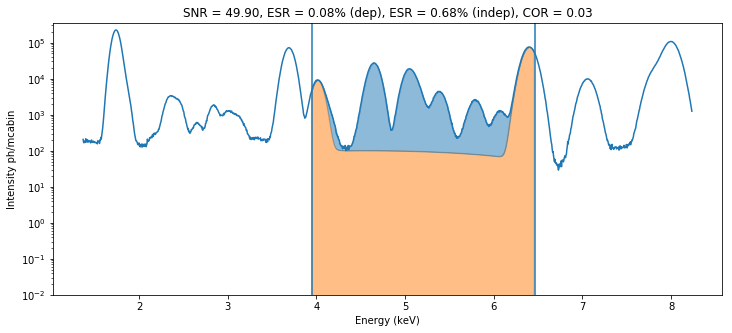

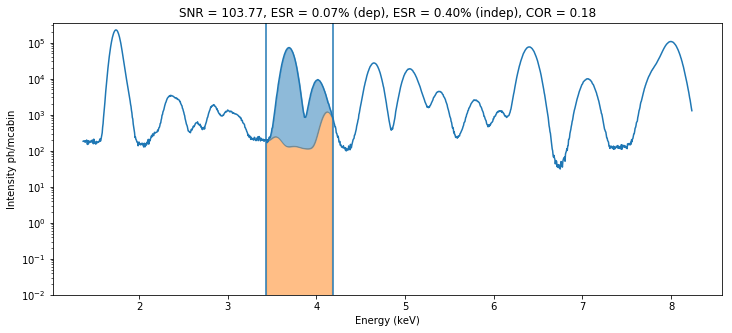

In [18]:
from spectrocrunch.materials import xrayspectrum

if 'xrf' in experiments:
    # Define by name:
    #lines = [["Ca-K"], ["La-L"]]

    # Or define by element and energy-range
    def getfluolines(ele, emin, emax):
        lines = xrayspectrum.FluoLine.factory(energybounds=(ele, emin, emax))
        return list([ele+'-'+str(line) for line in lines])
    emin,emax = pymcahandle.emin, pymcahandle.emax
    lines = [getfluolines("La", emin, emax),
             getfluolines("Ca", emin, emax)]

    def SNR(spectrum, backfunc, lines, plot=True, plotlines=False, ylog=True):
        def linevalid(ln):
            return any(ln.startswith(str(line)) for line in lines)
        ret = spectrum.snr(linevalid,
                           fluxtime=pymcahandle.I0,
                           histogram=True,
                           backfunc=backfunc,
                           plot=plot,
                           kstd=3)
        if plotlines and plot:
            spectrum.plot(fluxtime=pymcahandle.I0,
                          histogram=True,
                          backfunc=backfunc,\
                          forcelines=True,
                          title=None,
                          legend=False,
                          ylog=True)
        elif ylog:
            plt.gca().set_yscale('log', basey=10)
        if ylog:
            plt.gca().set_ylim(bottom=0.01)
        #plt.xlim((1,3))
        return ret
    
    nfrac = pymcahandle.sample.mixlayers().elemental_molefractions()
    wfrac = pymcahandle.sample.mixlayers().elemental_massfractions()
    wfit = fitresult['massfractions']
    for sublines in lines:
        plt.figure(figsize=(12,5))
        ele = element.Element(sublines[0].split('-')[0])
        relerror = SNR(spectrum, backfunc, sublines)['ESR (independent)']
        wfracele = wfrac[ele]
        wfitele = np.nan
        for k, v in wfit.items():
            if k.element == ele:
                wfitele = v
        wfiterr = (wfitele-wfracele)/wfracele
        print('{}:\n FP stdev/signal = {:.02f}%\n nfrac = {} ppm\n wfrac = {} wppm\n wfit = {} wppm ({:.02f}%)'
              .format(ele, relerror*100, nfrac[ele]*1e6, wfracele*1e6, wfitele*1e6, wfiterr*100))

        sublines = [ele.fluolines(line.split('-')[1]) for line in sublines]
        i = np.argmax([spectrum[line] for line in sublines])
        maxline = sublines[i]
        energy = maxline.energy()
        spectrumi = np.argmin(np.abs(spectrum_energy-energy))
        mci = np.argmin(np.abs(mc_energy-energy))
        matrixi = np.argmin(np.abs(matrix_energy-energy))
        err = (spectrum_counts[spectrumi]-mc_counts[mci])/mc_counts[mci]
        print(' {}:'.format(maxline))
        print('  FP error = {:.02f}%'.format(err*100))
        err = (matrix_counts[matrixi]-mc_counts[mci])/mc_counts[mci]
        print('  Matrix error = {:.02f}%'.format(err*100))